In [14]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
from sklearn import linear_model, model_selection
import os

In [50]:
%matplotlib notebook

In [8]:
file_list = os.listdir('./results/')
n_res = len(file_list)


In [9]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
    
    phi += 0.01*np.random.rand(phi.shape[0])
    theta += 0.01*np.random.rand(theta.shape[0])


    nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [45]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

X_train = pd.concat(nn_input_train).to_numpy()
X_test = pd.concat(nn_input_test).to_numpy()

Y_train = pd.concat(nn_output_train).to_numpy()
Y_test = pd.concat(nn_output_test).to_numpy()

nx = X_train.shape[1]
ny = Y_train.shape[1]

# Create DNN:

In [31]:
n_layer = 4          # This includes the output layer. n_layer-1 is the number of hidden layers.
n_units = 70         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nx
model_param['n_out'] = ny
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='mse', optimizer='Adam')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 70)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_2 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 426       
Total params: 10,646
Trainable params: 10,646
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, 
                    Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size=100, 
                    epochs=1000)

Train on 10500 samples, validate on 3500 samples
Epoch 1/1000
10500/10500 [==============================] - 1s 54us/sample - loss: 13.2963 - val_loss: 1.4776
Epoch 2/1000
10500/10500 [==============================] - 0s 25us/sample - loss: 0.9976 - val_loss: 1.1141
Epoch 3/1000
10500/10500 [==============================] - 0s 27us/sample - loss: 0.8542 - val_loss: 1.0356
Epoch 4/1000
10500/10500 [==============================] - 0s 26us/sample - loss: 0.7550 - val_loss: 0.9741
Epoch 5/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.6750 - val_loss: 0.9273
Epoch 6/1000
10500/10500 [==============================] - 0s 27us/sample - loss: 0.6290 - val_loss: 0.8976
Epoch 7/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.6028 - val_loss: 0.8716
Epoch 8/1000
10500/10500 [==============================] - 0s 27us/sample - loss: 0.5786 - val_loss: 0.8443
Epoch 9/1000
10500/10500 [==============================] - 0s 28us/sample - l

10500/10500 [==============================] - 0s 29us/sample - loss: 0.1596 - val_loss: 0.3612
Epoch 76/1000
10500/10500 [==============================] - 1s 66us/sample - loss: 0.1610 - val_loss: 0.3408
Epoch 77/1000
10500/10500 [==============================] - 1s 68us/sample - loss: 0.1598 - val_loss: 0.3365
Epoch 78/1000
10500/10500 [==============================] - 1s 68us/sample - loss: 0.1576 - val_loss: 0.3689
Epoch 79/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1581 - val_loss: 0.3673
Epoch 80/1000
10500/10500 [==============================] - 0s 24us/sample - loss: 0.1578 - val_loss: 0.3398
Epoch 81/1000
10500/10500 [==============================] - 1s 53us/sample - loss: 0.1563 - val_loss: 0.3592
Epoch 82/1000
10500/10500 [==============================] - 0s 38us/sample - loss: 0.1562 - val_loss: 0.3332
Epoch 83/1000
10500/10500 [==============================] - 0s 26us/sample - loss: 0.1545 - val_loss: 0.3393
Epoch 84/1000
10500/1050

10500/10500 [==============================] - 0s 21us/sample - loss: 0.1332 - val_loss: 0.3177
Epoch 150/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1320 - val_loss: 0.3374
Epoch 151/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1308 - val_loss: 0.3097
Epoch 152/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1323 - val_loss: 0.3185
Epoch 153/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1316 - val_loss: 0.3288
Epoch 154/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1316 - val_loss: 0.3184
Epoch 155/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.1318 - val_loss: 0.3347
Epoch 156/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1301 - val_loss: 0.3117
Epoch 157/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.1307 - val_loss: 0.3203
Epoch 158/1000
1

Epoch 223/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1212 - val_loss: 0.3261
Epoch 224/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1193 - val_loss: 0.3270
Epoch 225/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1215 - val_loss: 0.3237
Epoch 226/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1216 - val_loss: 0.3157
Epoch 227/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1200 - val_loss: 0.3503
Epoch 228/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1210 - val_loss: 0.3221
Epoch 229/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1204 - val_loss: 0.3350
Epoch 230/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1197 - val_loss: 0.3362
Epoch 231/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.1196 - val_loss: 0.3378
E

Epoch 297/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1137 - val_loss: 0.3362
Epoch 298/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.1126 - val_loss: 0.3605
Epoch 299/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1135 - val_loss: 0.3455
Epoch 300/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1125 - val_loss: 0.3306
Epoch 301/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.1142 - val_loss: 0.3431
Epoch 302/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1126 - val_loss: 0.3387
Epoch 303/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1130 - val_loss: 0.3265
Epoch 304/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1154 - val_loss: 0.3291
Epoch 305/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1135 - val_loss: 0.3486
E

Epoch 371/1000
10500/10500 [==============================] - 0s 27us/sample - loss: 0.1093 - val_loss: 0.3247
Epoch 372/1000
10500/10500 [==============================] - 0s 29us/sample - loss: 0.1084 - val_loss: 0.3314
Epoch 373/1000
10500/10500 [==============================] - 0s 28us/sample - loss: 0.1102 - val_loss: 0.3499
Epoch 374/1000
10500/10500 [==============================] - 0s 26us/sample - loss: 0.1081 - val_loss: 0.3379
Epoch 375/1000
10500/10500 [==============================] - 0s 24us/sample - loss: 0.1087 - val_loss: 0.3331
Epoch 376/1000
10500/10500 [==============================] - 0s 25us/sample - loss: 0.1085 - val_loss: 0.3457
Epoch 377/1000
10500/10500 [==============================] - 0s 28us/sample - loss: 0.1084 - val_loss: 0.3417
Epoch 378/1000
10500/10500 [==============================] - 1s 52us/sample - loss: 0.1072 - val_loss: 0.3422
Epoch 379/1000
10500/10500 [==============================] - 0s 39us/sample - loss: 0.1086 - val_loss: 0.3665
E

Epoch 445/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1045 - val_loss: 0.3522
Epoch 446/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1047 - val_loss: 0.3440
Epoch 447/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1040 - val_loss: 0.3326
Epoch 448/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.1044 - val_loss: 0.3335
Epoch 449/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1053 - val_loss: 0.3652
Epoch 450/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.1040 - val_loss: 0.3572
Epoch 451/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.1061 - val_loss: 0.3151
Epoch 452/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.1048 - val_loss: 0.3735
Epoch 453/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.1044 - val_loss: 0.3472
E

Epoch 519/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1018 - val_loss: 0.3351
Epoch 520/1000
10500/10500 [==============================] - 0s 30us/sample - loss: 0.1009 - val_loss: 0.3431
Epoch 521/1000
10500/10500 [==============================] - 0s 24us/sample - loss: 0.1025 - val_loss: 0.3566
Epoch 522/1000
10500/10500 [==============================] - 0s 27us/sample - loss: 0.1018 - val_loss: 0.3411
Epoch 523/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.1010 - val_loss: 0.3308
Epoch 524/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.1009 - val_loss: 0.3283
Epoch 525/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.1017 - val_loss: 0.3416
Epoch 526/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.1001 - val_loss: 0.3502
Epoch 527/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.1022 - val_loss: 0.3508
E

Epoch 593/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.0989 - val_loss: 0.3418
Epoch 594/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.0980 - val_loss: 0.3374
Epoch 595/1000
10500/10500 [==============================] - 0s 34us/sample - loss: 0.0995 - val_loss: 0.3444
Epoch 596/1000
10500/10500 [==============================] - 0s 26us/sample - loss: 0.0997 - val_loss: 0.3255
Epoch 597/1000
10500/10500 [==============================] - 0s 23us/sample - loss: 0.0992 - val_loss: 0.3517
Epoch 598/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.0979 - val_loss: 0.3350
Epoch 599/1000
10500/10500 [==============================] - 0s 17us/sample - loss: 0.0983 - val_loss: 0.3524
Epoch 600/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0990 - val_loss: 0.3690
Epoch 601/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.1002 - val_loss: 0.3325
E

Epoch 667/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.0953 - val_loss: 0.3548
Epoch 668/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.0964 - val_loss: 0.3490
Epoch 669/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0966 - val_loss: 0.3415
Epoch 670/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0953 - val_loss: 0.3403
Epoch 671/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.0950 - val_loss: 0.3486
Epoch 672/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.0956 - val_loss: 0.3603
Epoch 673/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0963 - val_loss: 0.3456
Epoch 674/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0951 - val_loss: 0.3550
Epoch 675/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0968 - val_loss: 0.3572
E

Epoch 741/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0935 - val_loss: 0.3434
Epoch 742/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.0935 - val_loss: 0.3562
Epoch 743/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.0943 - val_loss: 0.3347
Epoch 744/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.0938 - val_loss: 0.3555
Epoch 745/1000
10500/10500 [==============================] - 0s 18us/sample - loss: 0.0933 - val_loss: 0.3569
Epoch 746/1000
10500/10500 [==============================] - 0s 19us/sample - loss: 0.0930 - val_loss: 0.3518
Epoch 747/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.0928 - val_loss: 0.3480
Epoch 748/1000
10500/10500 [==============================] - 0s 21us/sample - loss: 0.0930 - val_loss: 0.3383
Epoch 749/1000
10500/10500 [==============================] - 0s 22us/sample - loss: 0.0940 - val_loss: 0.3298
E

Epoch 815/1000
10500/10500 [==============================] - 1s 83us/sample - loss: 0.0924 - val_loss: 0.3583
Epoch 816/1000
10500/10500 [==============================] - 0s 38us/sample - loss: 0.0915 - val_loss: 0.3519
Epoch 817/1000
10500/10500 [==============================] - 0s 17us/sample - loss: 0.0921 - val_loss: 0.3488
Epoch 818/1000
10500/10500 [==============================] - 0s 25us/sample - loss: 0.0909 - val_loss: 0.3659
Epoch 819/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0914 - val_loss: 0.3542
Epoch 820/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0918 - val_loss: 0.3650
Epoch 821/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0932 - val_loss: 0.3291
Epoch 822/1000
10500/10500 [==============================] - 0s 16us/sample - loss: 0.0920 - val_loss: 0.3363
Epoch 823/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0914 - val_loss: 0.3594
E

Epoch 889/1000
10500/10500 [==============================] - 0s 14us/sample - loss: 0.0897 - val_loss: 0.3478
Epoch 890/1000
10500/10500 [==============================] - 0s 13us/sample - loss: 0.0898 - val_loss: 0.3488
Epoch 891/1000
10500/10500 [==============================] - 0s 13us/sample - loss: 0.0897 - val_loss: 0.3588
Epoch 892/1000
10500/10500 [==============================] - 0s 14us/sample - loss: 0.0910 - val_loss: 0.3545
Epoch 893/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0910 - val_loss: 0.3482
Epoch 894/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0905 - val_loss: 0.3677
Epoch 895/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0916 - val_loss: 0.3501
Epoch 896/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0895 - val_loss: 0.3401
Epoch 897/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0904 - val_loss: 0.3569
E

10500/10500 [==============================] - 0s 15us/sample - loss: 0.0894 - val_loss: 0.3715
Epoch 963/1000
10500/10500 [==============================] - 0s 16us/sample - loss: 0.0880 - val_loss: 0.3468
Epoch 964/1000
10500/10500 [==============================] - 0s 17us/sample - loss: 0.0888 - val_loss: 0.3445
Epoch 965/1000
10500/10500 [==============================] - 0s 34us/sample - loss: 0.0898 - val_loss: 0.3578
Epoch 966/1000
10500/10500 [==============================] - 0s 26us/sample - loss: 0.0897 - val_loss: 0.3528
Epoch 967/1000
10500/10500 [==============================] - 0s 20us/sample - loss: 0.0890 - val_loss: 0.3616
Epoch 968/1000
10500/10500 [==============================] - 0s 16us/sample - loss: 0.0878 - val_loss: 0.3470
Epoch 969/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0885 - val_loss: 0.3521
Epoch 970/1000
10500/10500 [==============================] - 0s 15us/sample - loss: 0.0890 - val_loss: 0.3461
Epoch 971/1000
1

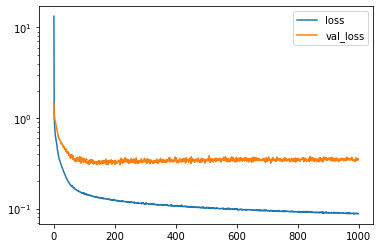

In [44]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'], label='loss')
ax.semilogy(history.history['val_loss'], label='val_loss')
ax.legend()

# Evaluate Model


In [53]:
test_with = 1
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    nn_in = in_i.to_numpy()
    nn_out = model.predict(nn_in.reshape(1,-1))
    res.append(nn_out)
res = np.concatenate(res, axis=0).squeeze()

In [54]:
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

<IPython.core.display.Javascript object>


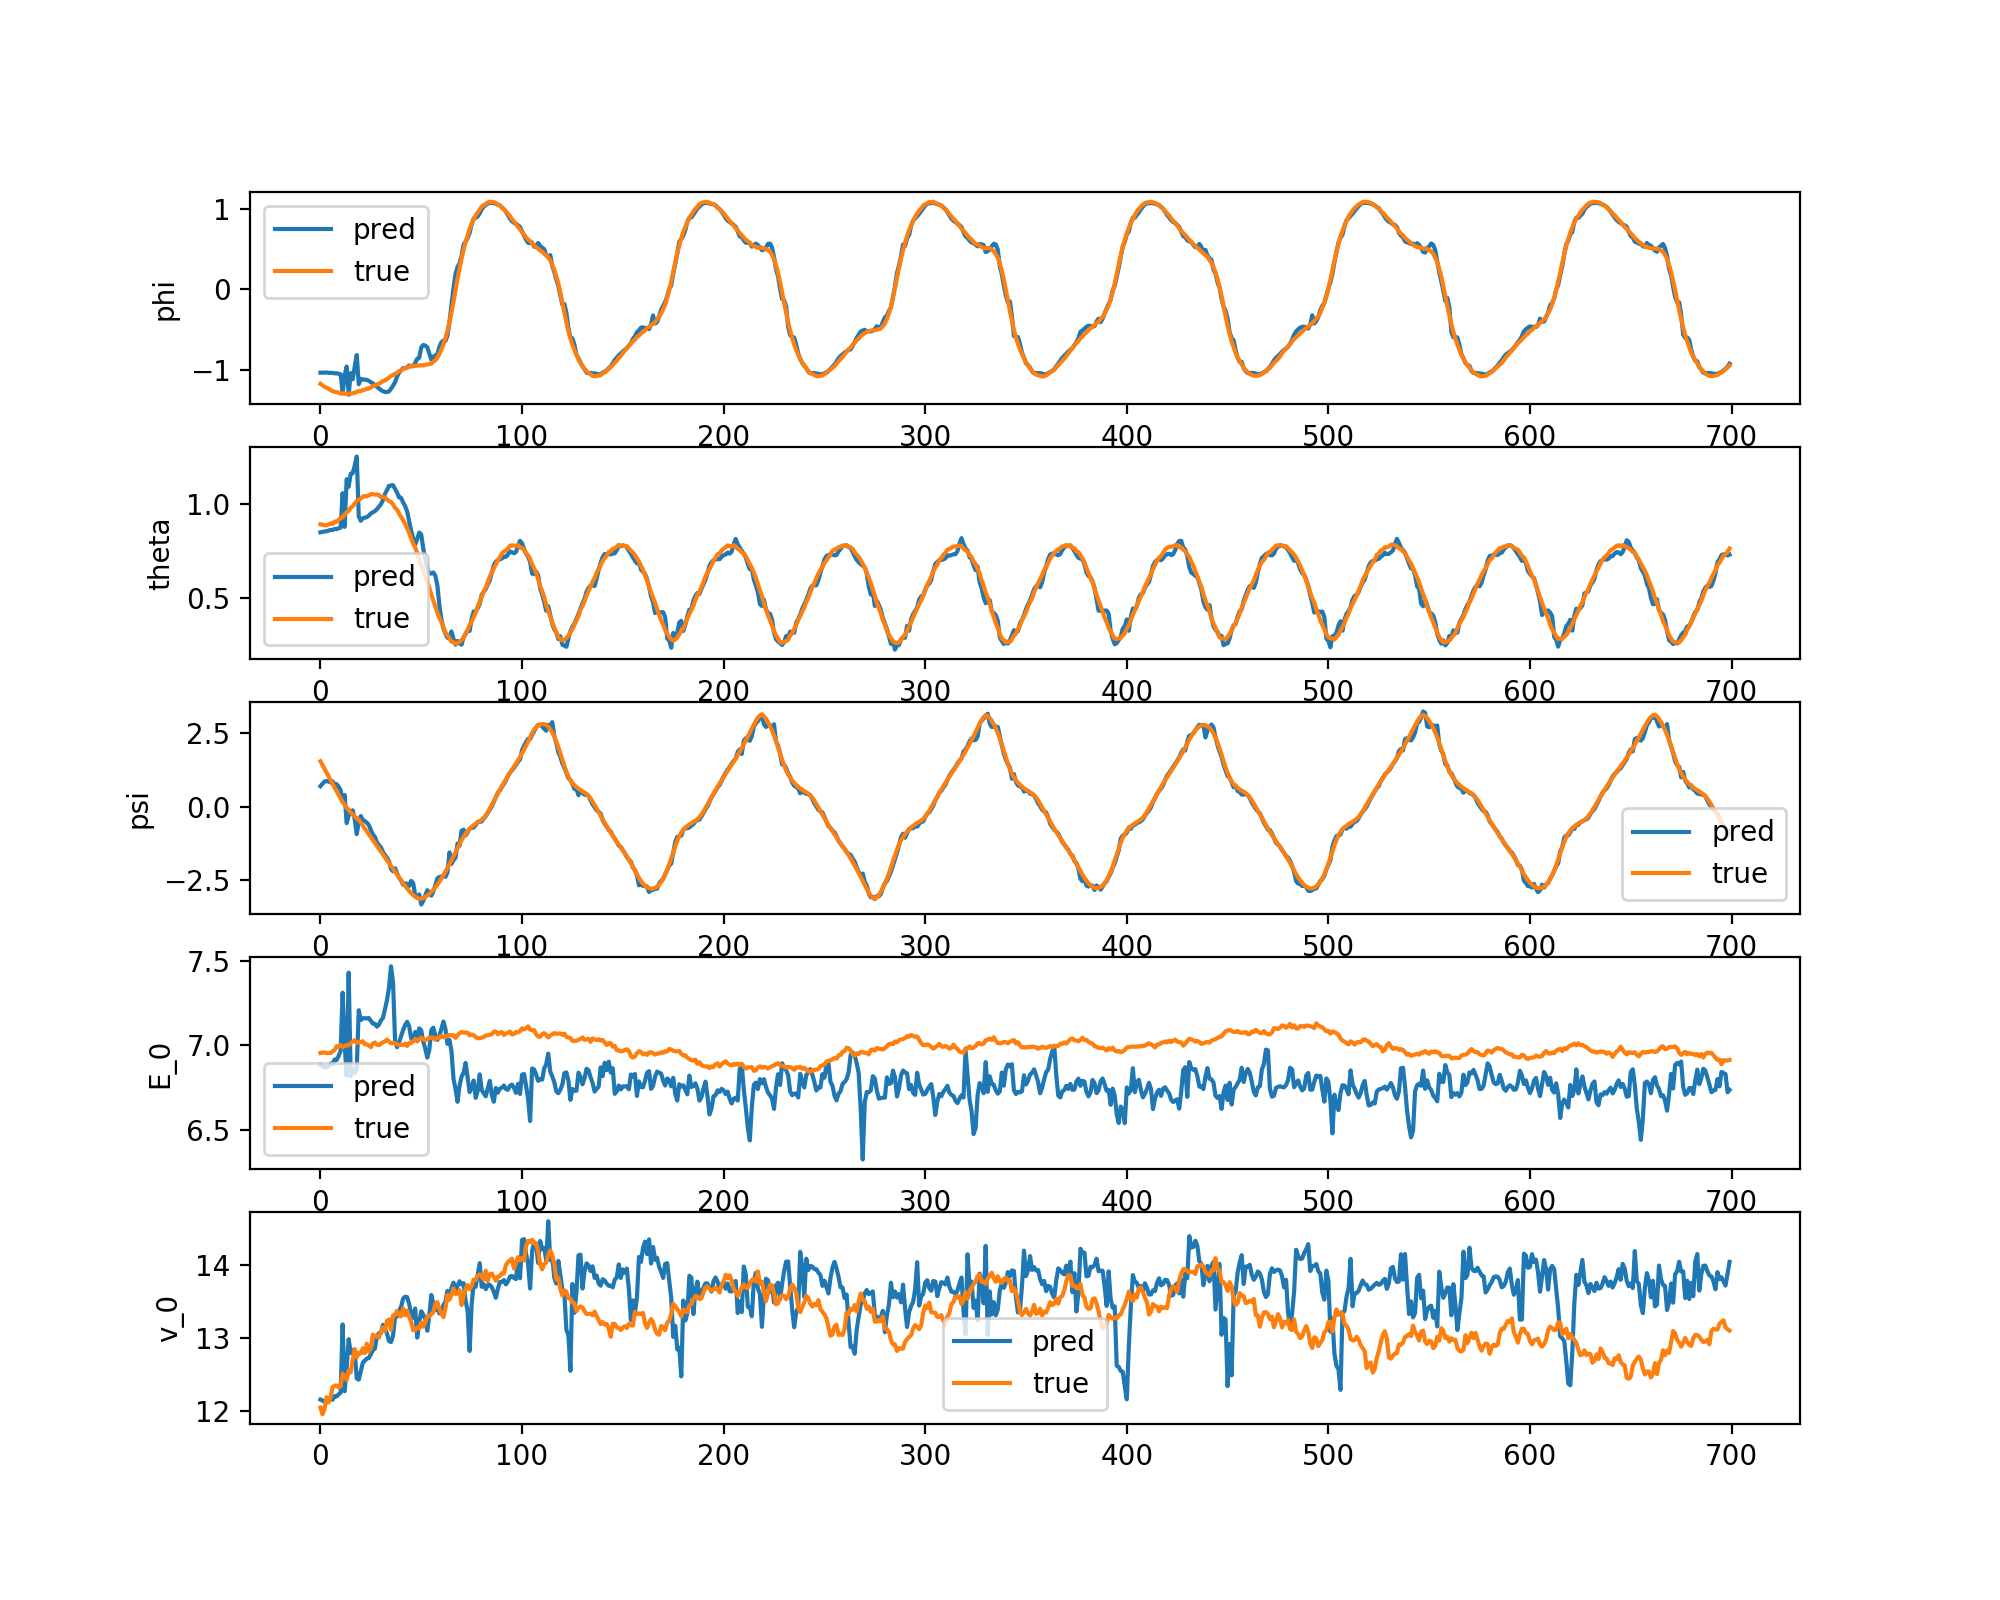

Text(0, 0.5, 'v_0')

In [55]:
fig, ax = plt.subplots(5, figsize=(10,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')